<a href="https://colab.research.google.com/github/GovindSinghShekhawat/NeuaralNetworks/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data

In [1]:
import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import keras 
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline 
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model 
from keras.optimizers import RMSprop

In [4]:
def extract_data(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(28 * 28 * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, 28, 28)
    return data

In [8]:
train_data = extract_data('/content/train-images-idx3-ubyte.gz',60000)
test_data = extract_data('/content/t10k-images-idx3-ubyte.gz',10000)

In [9]:
def extract_labels(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_images)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [10]:
train_labels = extract_labels('/content/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/t10k-labels-idx1-ubyte.gz',10000)

Data Exploration

In [11]:
print("Training set (images) shape: {shape}".format(shape=train_data.shape))
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [12]:
# Create dictionary of target classes
label_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    9: 'J'
}

Text(0.5, 1.0, '(Label: D)')

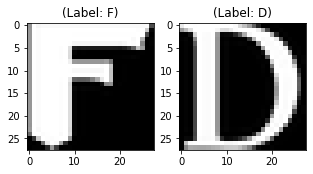

In [13]:
# Taking a look at couple of images in the dataset
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0],(28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

Data Processing

In [14]:
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [15]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [16]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [18]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [20]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                train_data,test_size=0.2,random_state=13)

The Convolutional Autoencoder

In [21]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [27]:
def autoencoder(input_img):
  #encoder
  #input = 28 x 28 x 1 (wide and thin)
  conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) #28x28x32
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14x14x32
  conv2 = Conv2D(64, (3,3), activation ='relu',padding='same')(pool1) #14x14x64
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2) #7x7x64
  conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) #7x7x128(narrow and thick)

  #decoder
  conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3) #7x7x128
  up1 = UpSampling2D((2,2))(conv4) #14x14x128
  conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up1) #14x14x64
  up2 = UpSampling2D((2,2))(conv5) #28x28x64
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2) #28x28x1
  return decoded

In [28]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [29]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         147584

Train the model

In [30]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 359s 953ms/step - loss: 0.0674 - val_loss: 0.0113
Epoch 2/50
375/375 [==============================] - 357s 951ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 3/50
375/375 [==============================] - 360s 961ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 4/50
375/375 [==============================] - 359s 958ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 5/50
375/375 [==============================] - 360s 959ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 6/50
375/375 [==============================] - 359s 957ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/50
375/375 [==============================] - 360s 959ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/50
375/375 [==============================] - 362s 966ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 9/50
375/375 [==============================] - 359s 956ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/50
375/375 [==============================] - 361s 964m

Training vs Validation Loss Plot

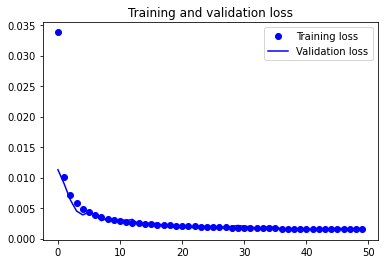

In [31]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Predicting on test data

In [32]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


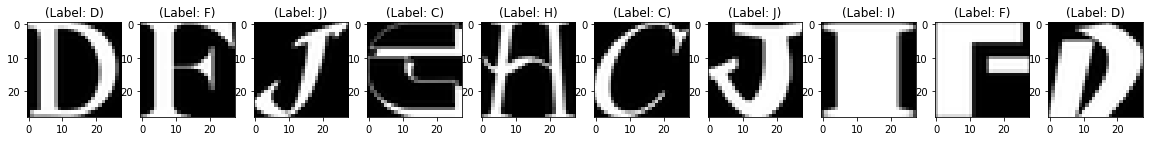

Reconstruction of Test Images


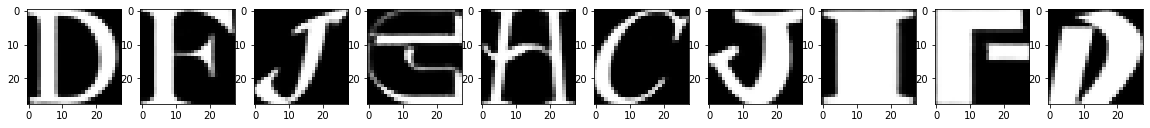

In [35]:
plt.figure(figsize=(20,4))
print("Test Images")
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(test_data[i, ...,0], cmap='gray')
  curr_lbl = test_labels[i]
  plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()
plt.figure(figsize=(20,4))
print("Reconstruction of Test Images")
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(pred[i, ..., 0], cmap = 'gray')
plt.show()